## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import random
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from pathlib import Path
from keras.preprocessing import image
from matplotlib import pyplot as plt
from medpy.metric import dc,precision,recall

## Data Preperation

In [2]:
p1 = Path("Data/Train/image/")
p2 = "Data/Train/mask/"
image_folder = p1.glob("*")
X_Train = []
Y_Train = []

for folder in image_folder:
    p2_new = p2 + folder.name + '/'
    folder = folder.glob("*")
    
    for img in folder:
        img_name = img.name
        img_new = 'Y' + img_name[1:]
        p2_final = p2_new + img_new
        
        imggX = image.load_img(img,target_size=(128,128))
        img_arrayX = image.img_to_array(imggX)
        X_Train.append(img_arrayX)
        
        imggY = image.load_img(p2_final,target_size=(128,128))
        img_arrayY = image.img_to_array(imggY)
        Y_Train.append(img_arrayY)
        """""""""""
        print(p2_final)
        print(img)
        print()
        """""""""""

p1 = Path("Data/Valid/image/")
p2 = "Data/Valid/mask/"
image_folder = p1.glob("*")

for folder in image_folder:
    p2_new = p2 + folder.name + '/'
    folder = folder.glob("*")
    
    for img in folder:
        img_name = img.name
        img_new = 'Y' + img_name[1:]
        p2_final = p2_new + img_new
        
        imggX = image.load_img(img,target_size=(128,128))
        img_arrayX = image.img_to_array(imggX)
        X_Train.append(img_arrayX)
        
        imggY = image.load_img(p2_final,target_size=(128,128))
        img_arrayY = image.img_to_array(imggY)
        Y_Train.append(img_arrayY)
        """""""""""
        print(p2_final)
        print(img)
        print()
        """""""""""
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)
print("X_Train: ", X_Train.shape)
print("Y_Train: ", Y_Train.shape)


p1 = Path("Data/Test/image/")
p2 = "Data/Test/mask/"
image_folder = p1.glob("*")
X_Test = []
Y_Test = []

for folder in image_folder:
    p2_new = p2 + folder.name + '/'
    folder = folder.glob("*")
    
    for img in folder:
        img_name = img.name
        img_new = 'Y' + img_name[1:]
        p2_final = p2_new + img_new
        
        imggX = image.load_img(img,target_size=(128,128))
        img_arrayX = image.img_to_array(imggX)
        X_Test.append(img_arrayX)
        
        imggY = image.load_img(p2_final,target_size=(128,128))
        img_arrayY = image.img_to_array(imggY)
        Y_Test.append(img_arrayY)
        """""""""""
        print(p2_final)
        print(img)
        print()
        """""""""""
X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)
print("X_Test: ", X_Test.shape)
print("Y_Test: ", Y_Test.shape)

X_Train/=255
X_Test/=255
Y_Train/=255
Y_Test/=255

mean = np.mean(X_Train)
std = np.std(X_Train)
X_Train -= mean
X_Train /= std
X_Test -= mean
X_Test /= std

X_Train:  (1729, 128, 128, 3)
Y_Train:  (1729, 128, 128, 3)
X_Test:  (542, 128, 128, 3)
Y_Test:  (542, 128, 128, 3)


## ResUNet

In [3]:
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("relu")(x)
    return x 

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv 

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = tf.keras.layers.Add()([conv, shortcut])
    return output 

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c

In [5]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((128, 128, 3))

    ## ENCODER 
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    # BRIDGE
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    # DECODER 
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [6]:
model = ResUNet()
model.summary()

2022-01-22 18:12:09.538548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 18:12:10.352521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 18:12:10.354683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 18:12:10.368823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[dice_coef])

In [8]:
model.fit(X_Train, Y_Train, validation_data = (X_Test,Y_Test),verbose=1, batch_size=16, epochs=10)

Epoch 1/10


2022-01-22 18:12:31.672573: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2022-01-22 18:12:54.122704: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-22 18:12:57.102813: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


109/109 [==============================] - 220s 2s/step - loss: 0.0408 - dice_coef: 0.4496 - val_loss: 0.0229 - val_dice_coef: 0.0769
Epoch 2/10
109/109 [==============================] - 165s 2s/step - loss: 0.0036 - dice_coef: 0.7275 - val_loss: 0.0129 - val_dice_coef: 0.2413
Epoch 3/10
109/109 [==============================] - 171s 2s/step - loss: 0.0026 - dice_coef: 0.8061 - val_loss: 0.0064 - val_dice_coef: 0.5713
Epoch 4/10
109/109 [==============================] - 196s 2s/step - loss: 0.0020 - dice_coef: 0.8427 - val_loss: 0.0090 - val_dice_coef: 0.5523
Epoch 5/10
109/109 [==============================] - 182s 2s/step - loss: 0.0018 - dice_coef: 0.8588 - val_loss: 0.0067 - val_dice_coef: 0.6697
Epoch 6/10
109/109 [==============================] - 174s 2s/step - loss: 0.0013 - dice_coef: 0.8941 - val_loss: 0.0071 - val_dice_coef: 0.6616
Epoch 7/10
109/109 [==============================] - 165s 2s/step - loss: 0.0018 - dice_coef: 0.8652 - val_loss: 0.0087 - val_dice_coef: 0.6

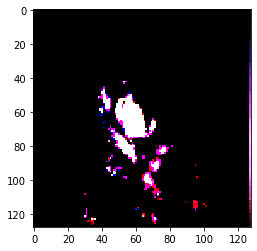

In [26]:
X_ = []
img_path = Path('Data/img1.png')
imggX = image.load_img(img_path,target_size=(128,128))
img_arrayX = image.img_to_array(imggX)
X_.append(img_arrayX)
X_ = np.array(X_)
Y_ = model.predict(X_)
from matplotlib import pyplot as plt
def plot_img(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()
plot_img(Y_[0])

### Image Segmentation using Contour Detection

In [28]:
# canny edge detection
import cv2
img = cv2.imread('img1.png')
img = cv2.resize(img,(256,256))
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

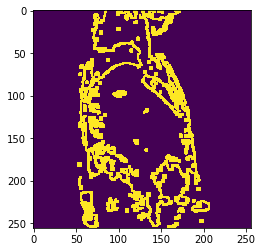

In [29]:
plot_img(edges)

In [31]:
#detecting contours 
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

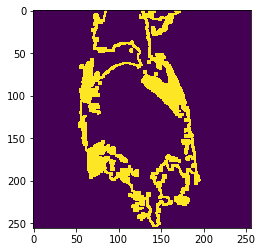

In [32]:
plot_img(masked)

In [33]:
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

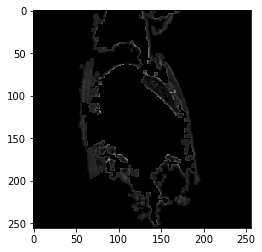

In [34]:
#Segmentation
plot_img(segmented)

### Image Segmentation using Thresholding

In [36]:
from skimage.filters import threshold_otsu
img = cv2.imread('img1.png')
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray=cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY)
def filter_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])

thresh = threshold_otsu(img_gray)
img_otsu  = img_gray < thresh
filtered = filter_image(img, img_otsu)

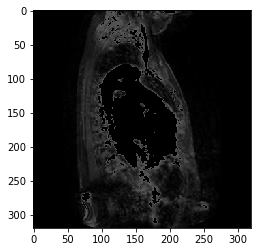

In [37]:
plot_img(filtered)

###  Image Segmentation using K-means

In [41]:
img = cv2.imread('img1.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

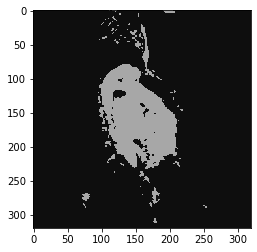

In [42]:
plot_img(result_image)

### Prediction Parameters

In [44]:
test_pred = model.predict(X_Test, batch_size=32) 
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, Y_Test)
pre  = precision(test_result,Y_Test)
re   = recall(test_result,Y_Test)

2022-01-22 20:09:10.572204: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-22 20:09:36.168487: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [45]:
print("Dice of the model is: ",dice)
print("Precision of the model is: ",pre)
print("Recall of the model is: ",re)

Dice of the model is:  0.7354318860277165
Precision of the model is:  0.8748827070491259
Recall of the model is:  0.6343245308296962


In [9]:
model.save_weights('resunet_dice74_10epochs.h5')

## U-Net Model

In [17]:
def U_Net():

    inputs=Input((160,160,3))
    conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
    
    conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
       
    
    conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
   
    conv4 = Conv2D(256, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3,activation = 'elu',  padding = 'same',kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
      
    merge7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    
    conv7 = Conv2D(128, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(merge7)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(128, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    
    merge8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    
    conv8 = Conv2D(64, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    merge9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    
    conv9 = Conv2D(32, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'elu', padding = 'same',kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10= Conv2D(3, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [18]:
model_new = U_Net()
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 160, 160, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 160, 160, 32  9248        ['conv2d_30[0][0]']              
                                )                                                           

In [19]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [20]:
optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model_new.compile(loss=['categorical_crossentropy'], optimizer=optimizer, metrics=[dice_coef,'accuracy'])

/home/anirudh/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training the U-Net Model

In [10]:
history = model_new.fit(X_Train,Y_Train,batch_size=32, epochs=10,validation_data = (X_Val,Y_Val),verbose=1,shuffle=True)

Epoch 1/10


2022-01-09 14:55:55.225217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2022-01-09 14:56:23.257948: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-09 14:56:24.484449: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-09 14:56:24.484538: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

37/37 [==============================] - 199s 4s/step - loss: 0.0174 - dice_coef: 0.0193 - accuracy: 0.3688 - val_loss: 0.0545 - val_dice_coef: 0.0021 - val_accuracy: 0.4929
Epoch 2/10
37/37 [==============================] - 133s 4s/step - loss: 0.0189 - dice_coef: 0.0234 - accuracy: 0.5009 - val_loss: 0.0718 - val_dice_coef: 0.0297 - val_accuracy: 0.4070
Epoch 3/10
37/37 [==============================] - 133s 4s/step - loss: 0.0171 - dice_coef: 0.0304 - accuracy: 0.5464 - val_loss: 0.0221 - val_dice_coef: 0.2063 - val_accuracy: 0.4316
Epoch 4/10
37/37 [==============================] - 134s 4s/step - loss: 0.0447 - dice_coef: 0.0476 - accuracy: 0.5597 - val_loss: 0.0532 - val_dice_coef: 0.0908 - val_accuracy: 0.3367
Epoch 5/10
37/37 [==============================] - 133s 4s/step - loss: 0.0584 - dice_coef: 0.0806 - accuracy: 0.5734 - val_loss: 0.0706 - val_dice_coef: 0.5177 - val_accuracy: 0.4914
Epoch 6/10
37/37 [==============================] - 134s 4s/step - loss: 0.0508 - dice

In [11]:
model_new.save_weights('dice84.h5')

In [12]:
model_new.evaluate(X_Test, Y_Test)

17/17 [==============================] - 27s 2s/step - loss: 0.0465 - dice_coef: 0.7105 - accuracy: 1.0000


[0.046544935554265976, 0.7105074524879456, 1.0]

In [21]:
model_new.load_weights('dice84.h5')

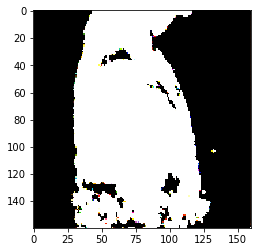

In [23]:
X_ = []
img = Path("Data/img1.png")
imggX = image.load_img(img,target_size=(160,160))
img_arrayX = image.img_to_array(imggX)
X_.append(img_arrayX)
X_ = np.array(X_)
Y_ = model_new.predict(X_)
from matplotlib import pyplot as plt
def plot_img(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()
plot_img(Y_[0])

### Plottings for U-Net Model

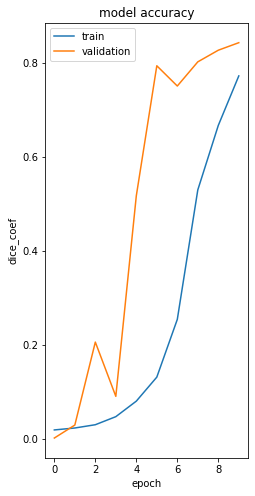

In [18]:
def plot_learning_curve_dice(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model accuracy')
    plt.ylabel('dice_coef')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
plot_learning_curve_dice(history)

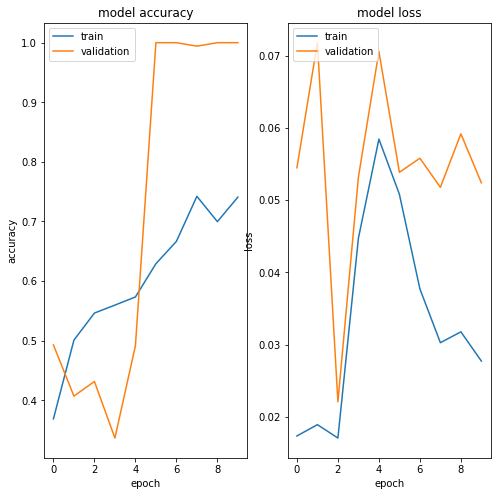

In [19]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
plot_learning_curve(history)

### Results for U-Net Model

In [22]:
test_pred = model_new.predict(X_Test, batch_size=32) 
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, Y_Test)
pre  = precision(test_result,Y_Test)
re   = recall(test_result,Y_Test)

In [26]:
print("Dice of the model is: ",dice)
print("Precision of the model is: ",pre)
print("Recall of the model is: ",re)

Dice of the model is:  0.7377518538936212
Precision of the model is:  0.7893675317756298
Recall of the model is:  0.6924720413954265


## CNN Model

In [6]:
def CNN():    
    simple_cnn = Sequential()
    simple_cnn.add(BatchNormalization(input_shape = (None, None, 3),name = 'NormalizeInput'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # dilations to get a slightly larger field of view
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
    simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
    simple_cnn.add(Conv2D(3, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
    return simple_cnn

In [7]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
model_cnn = CNN()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NormalizeInput (BatchNormal  (None, None, None, 3)    12        
 ization)                                                        
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 8)     224       
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 32)    4640      
                                                      

In [10]:
optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model_cnn.compile(loss=['categorical_crossentropy'], optimizer=optimizer, metrics=[dice_coef,'accuracy'])

### Training the CNN Model 

In [12]:
history1 = model_cnn.fit(X_Train,Y_Train,batch_size=32, epochs=10,validation_data = (X_Val,Y_Val),verbose=1,shuffle=True)

2022-01-09 15:44:18.842797: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 356352000 exceeds 10% of free system memory.


Epoch 1/10
37/37 [==============================] - 51s 1s/step - loss: 0.0200 - dice_coef: 0.0372 - accuracy: 0.1928 - val_loss: 0.0356 - val_dice_coef: 0.0521 - val_accuracy: 0.7290
Epoch 2/10
37/37 [==============================] - 52s 1s/step - loss: 0.7169 - dice_coef: 0.0450 - accuracy: 0.9646 - val_loss: 4.9163 - val_dice_coef: 0.0399 - val_accuracy: 0.9996
Epoch 3/10
37/37 [==============================] - 55s 2s/step - loss: 47.2726 - dice_coef: 0.0433 - accuracy: 0.9999 - val_loss: 130.2905 - val_dice_coef: 0.0422 - val_accuracy: 1.0000
Epoch 4/10
37/37 [==============================] - 52s 1s/step - loss: 608.6564 - dice_coef: 0.0463 - accuracy: 1.0000 - val_loss: 1234.9718 - val_dice_coef: 0.0455 - val_accuracy: 1.0000
Epoch 5/10
37/37 [==============================] - 51s 1s/step - loss: 9006.2021 - dice_coef: 0.0493 - accuracy: 1.0000 - val_loss: 13432.4395 - val_dice_coef: 0.0486 - val_accuracy: 1.0000
Epoch 6/10
37/37 [==============================] - 51s 1s/step -

In [13]:
model_cnn.evaluate(X_Test, Y_Test)

17/17 [==============================] - 16s 935ms/step - loss: 14972801.0000 - dice_coef: 0.0522 - accuracy: 1.0000


[14972801.0, 0.05220600590109825, 0.9999996423721313]

### Plottings for CNN Model

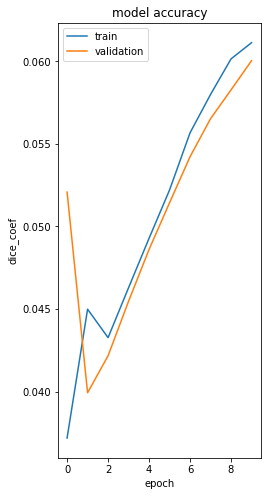

In [14]:
def plot_learning_curve_dice(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model accuracy')
    plt.ylabel('dice_coef')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
plot_learning_curve_dice(history1)

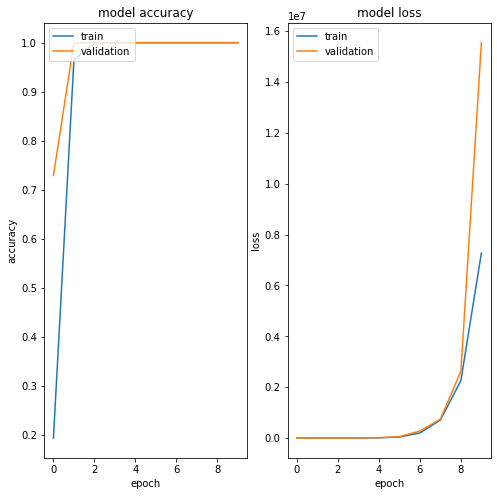

In [15]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
plot_learning_curve(history1)

### Results for CNN Model

In [16]:
test_pred = model_cnn.predict(X_Test, batch_size=32) 
test_result = np.zeros(test_pred.shape)
test_result[test_pred>0.5] = 1
test_result[test_pred<=0.5] = 0
dice = dc(test_result, Y_Test)
pre  = precision(test_result,Y_Test)
re   = recall(test_result,Y_Test)

In [17]:
print("Dice of the model is: ",dice)
print("Precision of the model is: ",pre)
print("Recall of the model is: ",re)

Dice of the model is:  0.05238239032577476
Precision of the model is:  0.026898489682547554
Recall of the model is:  0.9960540811216825
